### Decision Tree (DecisionTree.ipynb)
Train a Decision Tree classifier, selecting a rule for when it is time to stop branching to
avoid overfitting.

Goal: See how a ChoiceMaker performs when applied to a novel area. Having the lowest error 
compared to naive methods would be great.

Comparison: We compare against a naive way of making a decision tree algorithm
private, as well as another method described in a sketchy paper. I implemented
everything.

Current Results: The Choicemaker seems to be competitive with the two other methods
sometimes. We definitely need more data supporting this claim for a final submission.

Improvement 1: figure out a way to make epsilon equal to 1.0 always.
Improvement 2: simplify the error computations.


In [1]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle
import collections

In [2]:
from decision_tree import CoefCM, Leaf, Split, DB, DBMetas, PDTree

In [3]:
tree_algs = {'leaf': Leaf(), 'split': Split()}
fried_cm = CoefCM([1, 0, 1, 0, -1, 0, -1], np.log(1.414))

### DATASETS

In [4]:
adult = pickle.load(open('decision_tree_data/adult.pkl', 'rb'))

nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x.astype('category'))

default = pickle.load(open('decision_tree_data/default.pkl', 'rb'))

loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

lending = pickle.load(open('decision_tree_data/lending.pkl', 'rb'))

In [5]:
class null_cm:
    def __init__(self):
        self.leaf = Leaf()
        self.split = Split()
    def choose(self, db):
        if db.depth < db.max_depth:
            return self.split.run(db)
        else:
            return self.leaf.run(db)

### Experiments

In [6]:
def get_train_dbs(seed_db, eps, prng):
    regs = []
    X = []
    D = []
    for l in range(1, 4): #Used to be 6
        for x in range(2**(l+3)):
            cols = prng.permutation(seed_db.columns[:-1])
            db_groups = seed_db.groupby(list(cols[:l])).groups
            idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
            L = idxs.size
            L = min(L, 5000)
            L = prng.randint(0.7*L, L)
            idxs = prng.choice(idxs, L)
            data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
            regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
            X.append(DBMetas()(data))
            D.append(data)
    #Large DBs    
    for x in range(16):
        cols = seed_db.columns[:-1]
        L = len(seed_db)
        L = min(L, 5000)
        L = prng.randint(0.7*L, L)
        new_db = seed_db.sample(L, random_state=prng)
        data = DB(new_db.loc[:, cols], new_db.loc[:, seed_db.columns[-1]], None, None, epsilon=eps, depth=0)
        regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
        X.append(DBMetas()(data))
        D.append(data)
    return (regs, X, D)

In [7]:
def get_test_dbs(seed_db, eps, prng):
    cols = seed_db.columns[:-1]
    y_col = seed_db.columns[-1]
    L = len(seed_db)
    L = min(L, int(5000/0.7))
    L = prng.randint(0.7*L, L)
    new_db = seed_db.sample(L, random_state=prng).reset_index(drop=True)
    split = int(0.7*L)
    md = min(len(cols), 4)
    d = DB(new_db.loc[:split, cols], new_db.loc[:split, y_col], \
           new_db.loc[split:, cols], new_db.loc[split:, y_col], epsilon=eps, max_depth=md)
    return d

In [ ]:
prng=np.random.RandomState(12345)
eps_vals = np.array([0.05, 0.1, 0.25, 0.5, 0.8])
def get_test(db, prng):
    dbs = []
    for i in range(0, 3):
        for e in eps_vals:
            dbs.append(get_train_dbs(db, e, prng))
    return dbs
data_train = [get_test(db, prng) for db in [nurs, default, loan, adult, lending]]

In [48]:
def get_cm(info):
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return DTChoice(X, DBMetas(), tree_algs, regrets=regrets)

out = [get_cm(o) for o in data_train]

In [58]:
#pickle.dump([cm.X for cm in out], open('decision_tree_metadata/data2.pkl', 'wb'))
#pickle.dump([cm.regrets for cm in out], open('decision_tree_metadata/regrets2.pkl', 'wb'))

In [8]:
#We have already run the above code so you don't have to!
mfs = pickle.load(open('decision_tree_metadata/data2.pkl', 'rb'))
regs = pickle.load(open('decision_tree_metadata/regrets2.pkl', 'rb'))
tdbs = pickle.load(open('decision_tree_metadata/training_dbs.pkl', 'rb'))

In [9]:
cms = [ DTChoice(mfs[i], DBMetas(), tree_algs, regrets=regs[i]) for i in range(len(mfs))]

In [10]:
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, regrets=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=3)
    dt.retrain_model()
    return dt

In [11]:
def get_results(dbs, cm, cm2):
    dt = PDTree()
    budgets = [x.epsilon for x in dbs]
    L = []
    for t in dbs:
        L.append( dt.fit_and_predict(t, null_cm()) )
        print(dt.leaf.numruns)
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    dt = PDTree()
    L2 = []
    for t in dbs:
        L2.append(dt.fit_and_predict(t, cm))
        print(dt.leaf.numruns)
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    dt = PDTree()
    L3 = []
    for t in dbs:
        L3.append(dt.fit_and_predict(t, cm2))
        print(dt.leaf.numruns)
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M2 = np.array([(L2[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M3 = np.array([(L3[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    return (M, M2, M3)

In [12]:
prng = np.random.RandomState(12345)

In [13]:
[cm.regrets.groupby(cm.X.depth).mean() for cm in cms]

[           leaf     split
 depth                    
 0      0.670763  0.290492
 1      0.592515  0.252064
 2      0.505531  0.227715
 3      0.439362  0.259333,            leaf     split
 depth                    
 0      0.221413  0.191791
 1      0.246675  0.233749
 2      0.266957  0.255174
 3      0.260614  0.286893,            leaf     split
 depth                    
 0      0.097797  0.106767
 1      0.129402  0.179181
 2      0.203432  0.257402
 3      0.246144  0.290095,            leaf     split
 depth                    
 0      0.241172  0.241581
 1      0.231314  0.208118
 2      0.229867  0.243665
 3      0.254233  0.283510,            leaf     split
 depth                    
 0      0.216574  0.140478
 1      0.239620  0.206000
 2      0.262655  0.279596
 3      0.280774  0.354431]

### Experiment 0

In [14]:
#big_cm0 = cms[0]
big_cm0 = combine_cms(cms[1:])
big_cm0.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm0.retrain_model()

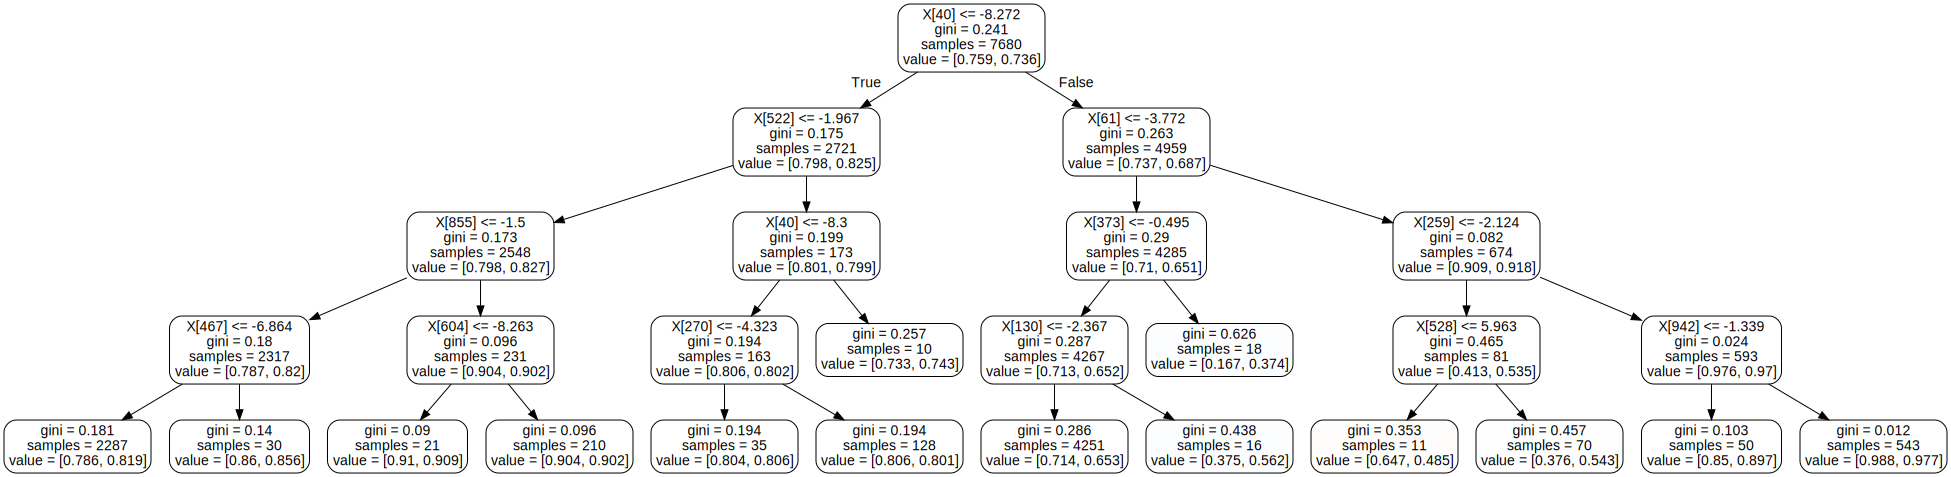

In [15]:
dot_data = export_graphviz(big_cm0.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [16]:
nursdata = get_test_dbs(nurs, 2.0, prng)

In [17]:
nurs1, nurs2, nurs3 = get_results([nursdata], big_cm0, fried_cm)

122
146
119


In [18]:
(nurs1.mean(), nurs2.mean(), nurs3.mean())

(0.6030395136778115, 0.58297872340425527, 0.60911854103343466)

### Experiment 1

In [173]:
#big_cm = combine_cms(out[:1] + out[2:])

In [19]:
big_cm1 = cms[1]
big_cm1.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm1.retrain_model()

In [24]:
defaultsdata = [get_test_dbs(default, 2.0, prng) for i in range(10)]

In [25]:
defaults1, defaults2, defaults3 = get_results(defaultsdata, big_cm1, fried_cm)

333
708
1038
1347
1639
1899
2205
2480
2775
3075
168
331
460
652
885
1103
1233
1389
1552
1734
60
150
233
307
385
459
522
571
621
692


In [26]:
(defaults1.mean(), defaults2.mean(), defaults3.mean())

(0.77938683701590095, 0.78997701676581999, 0.80390637827240341)

In [127]:
de = defaultsdata[0]
de.epsilon = 2

In [123]:
de.epsilon

2

In [125]:
big_cm1.choose(de)

array([0, 0, 0, ..., 0, 0, 0])

In [126]:
dt = PDTree()
P = dt.fit_and_predict(de, big_cm1)
(P == de.y_test).sum() / P.size

0.78856825749167592

In [111]:
pd.value_counts(P)

0    1802
dtype: int64

In [128]:
DBMetas()(de)

OrderedDict([('nrow', 4204),
             ('ncol', 23),
             ('eps', 2),
             ('depth', 0),
             ('C', 2),
             ('bf', 6.6956521739130439),
             ('t', 11)])

In [129]:
list(DBMetas()(de).values())

[4204, 23, 2, 0, 2, 6.6956521739130439, 11]

### Experiment 2

In [183]:
#big_cm2 = combine_cms(out[:2] + out[3:])

In [35]:
big_cm2 = cms[2]
big_cm2.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm2.retrain_model()

In [36]:
loandata = get_test_dbs(loan, 2.0, prng)

In [37]:
loans1, loans2, loans3 = get_results([loandata], big_cm2, fried_cm)

137
0
7


In [38]:
(loans1.mean(), loans2.mean(), loans3.mean())

(0.75694444444444442, 0.88888888888888884, 0.84375)

### Experiment 3

In [39]:
#big_cm3 = combine_cms(out[:3] + out[4:])
big_cm3 = cms[3]
big_cm3.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm3.retrain_model()

In [40]:
adultdata = get_test_dbs(adult, 2.0, prng)

In [41]:
adults1, adults2, adults3 = get_results([adultdata], big_cm3, fried_cm)

400
222
134


In [42]:
(adults1.mean(), adults2.mean(), adults3.mean())

(0.75182072829131652, 0.78711484593837533, 0.80336134453781516)

### Experiment 4

In [199]:
#big_cm4 = combine_cms(out[:4] + out[5:])

In [156]:
big_cm4 = cms[4]
big_cm4.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm4.retrain_model()

In [158]:
lendingdata = get_test_dbs(lending, 2.0, prng)

In [159]:
lendings1, lendings2, lendings3 = get_results([lendingdata], big_cm4, fried_cm)

328
269
120


In [160]:
(lendings1.mean(), lendings2.mean(), lendings3.mean())

(0.81575178997613362, 0.84391408114558475, 0.86109785202863964)

In [280]:
alg1_error = 1-np.array([nurs1, defaults1, loans1, adults1, lendings1])

In [281]:
alg2_error = 1-np.array([nurs2, defaults2, loans2, adults2, lendings2])

In [282]:
alg3_error = 1-np.array([nurs3, defaults3, loans3, adults3, lendings3])

In [283]:
#best = np.min([alg1_error, alg2_error, alg3_error], axis=0)
#avg_regret1 = (alg1_error-best).reshape((3,-1)).mean(axis=0)
#avg_regret2 = (alg2_error-best).reshape((3,-1)).mean(axis=0)
#avg_regret3 = (alg3_error-best).reshape((3,-1)).mean(axis=0)

In [284]:
alg1_error = alg1_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))
alg2_error = alg2_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))
alg3_error = alg3_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))

In [285]:
alg1_error = alg1_error.mean(axis=1)
alg2_error = alg2_error.mean(axis=1)
alg3_error = alg3_error.mean(axis=1)

In [293]:
juxtaposed_alg_perfs = np.array([alg1_error, alg3_error, alg2_error]).T.flatten()

In [294]:
x_pos = np.array([4*x + y for x in [0,1,2] for y in [0,1,2]])

In [295]:
colors = ['red', 'blue', 'green']*3

In [296]:
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=c) for c in ['red', 'blue', 'green']]

<Container object of 9 artists>

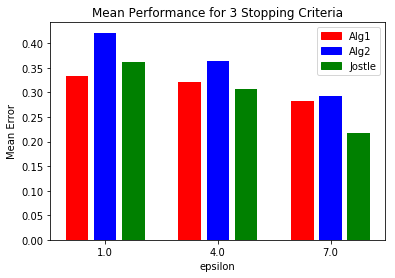

In [297]:
fig, axis = plt.subplots()
axis.set_xticks([1,5,9])
axis.set_xticklabels(['1.0', '4.0', '7.0'])
axis.set_xlabel('epsilon')
axis.set_ylabel('Mean Error')
axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
axis.set_title('Mean Performance for 3 Stopping Criteria')
axis.bar(x_pos, juxtaposed_alg_perfs, color=colors)

In [ ]:
fig, axis = plt.subplots()
for a in 